In [22]:
import os

import himalaya.scoring
import numpy as np
import pandas as pd
import seaborn as sns
import simplstyles
from himalaya.backend import set_backend
from himalaya.ridge import BandedRidgeCV, ColumnTransformerNoStack
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
from voxelwise_tutorials.delayer import Delayer

from fmri.features import load_brain_data, load_feature

In [23]:
backend = set_backend("torch_cuda", on_error='throw')
plt.style.use('nord-light-talk')
data_dir = "../../data"
simplstyles

<module 'simplstyles' from '/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/simplstyles/__init__.py'>

In [24]:
subject = 1
modality = "reading"

In [25]:
n_alphas_batch = 3
n_targets_batch = 100
n_targets_batch_refit = 50

In [26]:
number_of_delays = 4
alphas = np.logspace(-5, 20, 10)
cv = 5

In [27]:
def result_path(subject, modality, ridge_type, param_name, param_range):
    dir = f"results/brain_maps_validation_curves/{modality}/{subject}/{ridge_type}"
    os.makedirs(dir, exist_ok=True)
    path = os.path.join(dir, f"{param_name}_{param_range}.csv")
    return path

# Load features

In [28]:
X_semantic, n_samples_train = load_feature(data_dir, "english1000")
X_low_level, n_samples_train = load_feature(data_dir, "letters")
X = np.concatenate([X_semantic, X_low_level], axis=1)

# Load brain data

In [29]:
Y, n_samples_train = load_brain_data(data_dir, subject, modality)

/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/features.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Y_train = np.vstack([zscore(Y_train[story][:-trim]) for story in Y_train.keys()])
/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/features.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Y_train = np.vstack([zscore(Y_train[story][:-trim]) for story in Y_train.keys()])
/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/features.py:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  Y_train = np.vstack(

KeyboardInterrupt: 

# Iterations

In [37]:
n_iter_range = np.linspace(1, 15, 10).astype(int)
# turn to python ints
n_iter_range = np.unique(n_iter_range)
n_iter_range = [int(n_iter) for n_iter in n_iter_range]
n_iter_range

[1, 2, 4, 5, 7, 8, 10, 11, 13, 15]

In [38]:
cv_scores = pd.DataFrame()
for _n_iter in n_iter_range:
    print(_n_iter)
    path = result_path(subject, modality, "banded_ridge", "n_iter", _n_iter)
    if not os.path.exists(path):
        print("File does not exist")
        delayer = Delayer(delays=range(1, number_of_delays + 1))
        start_and_end = np.concatenate([[0], np.cumsum([X_semantic.shape[1], X_low_level.shape[1]])])
        slices = [slice(start, end) for start, end in zip(start_and_end[:-1], start_and_end[1:])]
        ct = ColumnTransformerNoStack(transformers=[(f'feature_{i}', delayer, s) for i, s in enumerate(slices)])

        solver_params = dict(
            alphas=alphas, n_iter=_n_iter, n_targets_batch=n_targets_batch,
            n_alphas_batch=n_alphas_batch, n_targets_batch_refit=n_targets_batch_refit,
            score_func=himalaya.scoring.r2_score)
        banded_ridge_cv = BandedRidgeCV(cv=cv, groups="input", solver_params=solver_params)

        pipeline = make_pipeline(
            ct,
            banded_ridge_cv
        )

        pipeline.fit(X[:n_samples_train], Y[:n_samples_train])

        prediction = pipeline.predict(X[n_samples_train:])
        prediction = backend.to_numpy(prediction)

        correlation = np.array([np.corrcoef(Y[n_samples_train:, i], prediction[:, i])[0, 1] for i in range(Y.shape[1])])

        # (n_iter, n_targets)
        cv_score = pipeline[-1].cv_scores_
        cv_score = max(cv_score, key=lambda x: x.mean())

        r2 = himalaya.scoring.r2_score(Y[n_samples_train:], prediction)
        r2 = backend.to_numpy(r2)

        result = pd.DataFrame(
            {
                'correlation_score': correlation,
                'cv_score': cv_score,
                'r2_score': r2
            }
        )

        result.to_csv(path)
        cv_scores[f"n_iter_{_n_iter}"] = result['r2_score']
    else:
        print("File exists")
        result = pd.read_csv(path)
        cv_scores[f"n_iter_{_n_iter}"] = result['r2_score']
cv_scores.head()

1
File exists
2
File exists
4
File exists
5
File exists
7
File exists
8
File does not exist


/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[                                        ] 0% | 0.00 sec | 8 random sampling with cv | 

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/himalaya/ridge/_random_search.py:140: UserWarning: Solving banded ridge is slower than solving multiple-kernel ridge when n_samples < n_features (here 3887 < 4044). Using linear kernels in himalaya.kernel_ridge.MultipleKernelRidgeCV or himalaya.kernel_ridge.solve_multiple_kernel_ridge_random_search would be faster. Use warn=False to silence this warning.
  warnings.warn(


[.........................               ] 62% | 320.45 sec | 8 random sampling with cv | 

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/himalaya/ridge/_random_search.py:388: UserWarning: torch.linalg.svd: During SVD computation with the selected cusolver driver, batches 0 failed to converge. A more accurate method will be used to compute the SVD as a fallback. Check doc at https://pytorch.org/docs/stable/generated/torch.linalg.svd.html (Triggered internally at /pytorch/aten/src/ATen/native/cuda/linalg/BatchLinearAlgebraLib.cpp:690.)
  U, eigenvalues, Vt = backend.svd(Xtrain, full_matrices=False)


[........................................] 100% | 517.42 sec | 8 random sampling with cv | 


/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


10
File exists
11
File does not exist


/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[                                        ] 0% | 0.00 sec | 11 random sampling with cv | 

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/himalaya/ridge/_random_search.py:140: UserWarning: Solving banded ridge is slower than solving multiple-kernel ridge when n_samples < n_features (here 3887 < 4044). Using linear kernels in himalaya.kernel_ridge.MultipleKernelRidgeCV or himalaya.kernel_ridge.solve_multiple_kernel_ridge_random_search would be faster. Use warn=False to silence this warning.
  warnings.warn(


[........................................] 100% | 1545.88 sec | 11 random sampling with cv | 


/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


13
File does not exist


/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[                                        ] 0% | 0.00 sec | 13 random sampling with cv | 

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/himalaya/ridge/_random_search.py:140: UserWarning: Solving banded ridge is slower than solving multiple-kernel ridge when n_samples < n_features (here 3887 < 4044). Using linear kernels in himalaya.kernel_ridge.MultipleKernelRidgeCV or himalaya.kernel_ridge.solve_multiple_kernel_ridge_random_search would be faster. Use warn=False to silence this warning.
  warnings.warn(


[........................................] 100% | 832.31 sec | 13 random sampling with cv | 


/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


15
File does not exist


/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[                                        ] 0% | 0.00 sec | 15 random sampling with cv | 

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/himalaya/ridge/_random_search.py:140: UserWarning: Solving banded ridge is slower than solving multiple-kernel ridge when n_samples < n_features (here 3887 < 4044). Using linear kernels in himalaya.kernel_ridge.MultipleKernelRidgeCV or himalaya.kernel_ridge.solve_multiple_kernel_ridge_random_search would be faster. Use warn=False to silence this warning.
  warnings.warn(


[........................................] 100% | 940.13 sec | 15 random sampling with cv | 


/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,n_iter_1,n_iter_2,n_iter_4,n_iter_5,n_iter_7,n_iter_8,n_iter_10,n_iter_11,n_iter_13,n_iter_15
0,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,-4.203757e+34,-4.203757e+34,-1.653865e+35,-1.490995e+35,-1.491287e+35,-1.479201e+35,-1.655466e+35,-1.655229e+35,-1.615075e+35,-1.653577e+35
2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,-1.703035e+14,-1.703035e+14,-1.703035e+14,-1.703035e+14,-1.703035e+14,-1.703035e+14,-1.703035e+14,-1.703035e+14,-1.703035e+14,-1.703035e+14


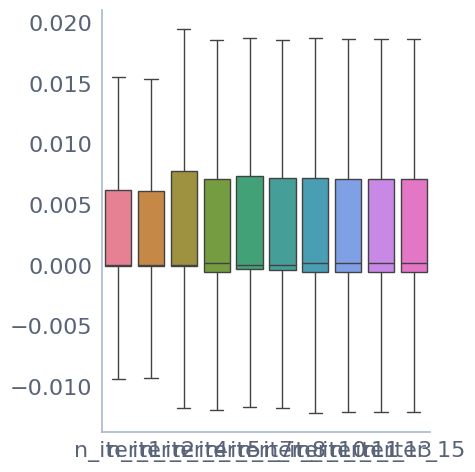

In [39]:
sns.catplot(data=cv_scores, kind='box', showfliers=False)

In [40]:
# plot the highest r2 score voxel for each iteration
best_voxels = [column.argmax() for column in cv_scores._iter_column_arrays()]
best_voxels

[np.int64(30425),
 np.int64(30425),
 np.int64(30425),
 np.int64(30425),
 np.int64(30425),
 np.int64(30425),
 np.int64(30425),
 np.int64(30425),
 np.int64(30425),
 np.int64(30425)]

In [41]:
# plot the r2 score of the best voxel for each iteration
best_voxels_scores = [cv_scores.iloc[best_voxel, i] for i, best_voxel in enumerate(best_voxels)]
best_voxels_scores

[np.float64(0.39186466),
 np.float64(0.39808142),
 np.float64(0.39186466),
 np.float64(0.43425405),
 np.float64(0.42258048),
 np.float32(0.42968863),
 np.float64(0.42899048),
 np.float32(0.4122535),
 np.float32(0.43391055),
 np.float32(0.4327796)]

([<matplotlib.axis.XTick at 0x74be4f8403b0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(13, 0, '13'),
  Text(15, 0, '15')])

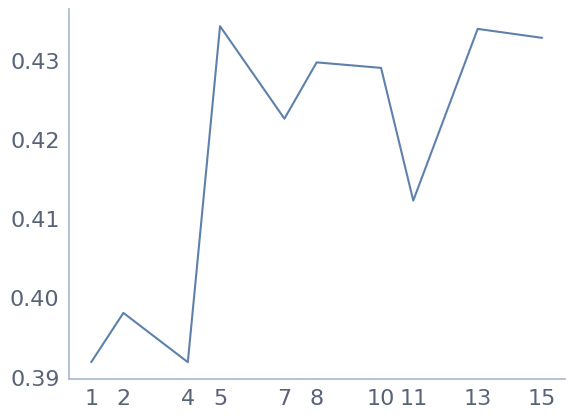

In [43]:
plt.plot(n_iter_range, best_voxels_scores)
plt.xticks(n_iter_range, n_iter_range)

In [72]:
# create the same plot for the top 10% of voxels of the last iteration
top_voxels = cv_scores.iloc[:, cv_scores.shape[1] - 1].nlargest(int(cv_scores.shape[0] * 0.05)).index
top_voxels

Index([30425, 36940, 19007, 19006, 30370, 26684, 53714,  9580, 19065,  6650,
       ...
       29740, 19808, 78393, 74018, 37734, 63630, 64286,  9044, 22483, 12951],
      dtype='int64', length=4056)

([<matplotlib.axis.XTick at 0x74bbdaf899d0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(13, 0, '13'),
  Text(15, 0, '15')])

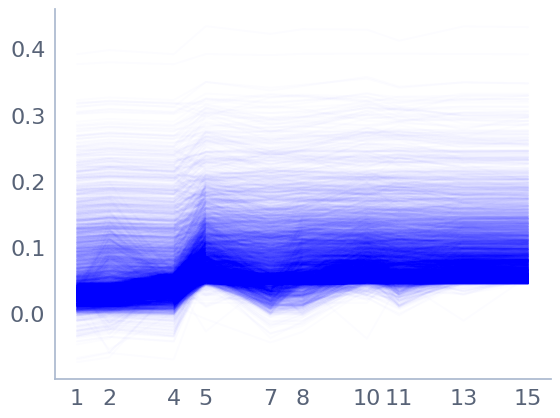

In [73]:
for i, top_voxel in enumerate(top_voxels):
    plt.plot(n_iter_range, [cv_scores.iloc[top_voxel, i] for i in range(len(n_iter_range))], alpha=0.01, color='blue')
plt.xticks(n_iter_range, n_iter_range)